In this notebook I will demonstrate one of the optimization problems introduced on the following hyperlink:\
[(https://tristanvanleeuwen.github.io/IP_and_Im_Lectures/variational_formulations.html)]

One of the optimization problems that occurs in various applications is related to the following functional:
$$J(u) = \int_{\Omega} \frac{1}{2}\left(u(x)-f(x)\right)^2 + r\left(\nabla u(x)\right)~\text{dx},$$
where $\Omega\subset\mathbb{R}^n$ and $r:\mathbb{R}^n\mapsto\mathbb{R}$.

Here, I will demonstrate the usage of the variational formulation of this function to denoise an image.

Let $J$ be such functional. The corresponding Euler-Lagrange equations are then given as:
$$u(x)-\nabla\cdot\left(\nabla r\left(\nabla u(x)\right)\right) = f(x),$$
with the boundary condition $\nabla r\left(\nabla u\right)\cdot n = 0$, where $n(x)$ is the outter normal at the point $x\in\partial\Omega$.\

As we know, the solution to the Euler-Lagrange equation is a stationary point of the function $J$. We can also express it as an evolution equation:
$$\partial_t u(t,x) + u(t,x) -\nabla\cdot\left(\nabla r\left(\nabla u(x)\right)\right) = f(x),$$
with the property that the solution of the equation $u$ converges to a stationary point of $J$, as $t\mapsto\infty$.

Let's now check the following example.

Let:
$$r(v)=||v||_2^2.$$
It follows that the corresponding equation is given as:
$$\partial _t u + u - \alpha\nabla^2 u = f.$$

By using forward differentation:
$$\partial _t u \approx \frac{u_{k+1}-u_k}{\Delta t},$$
at some time point $k$, we yield:
$$u_{k+1} = u_k -\Delta t\left(u - f - \alpha\nabla^2 u\right).$$

The code below demonstrates the solution to the evolution equation applied to the camera-man image given in the lecture.

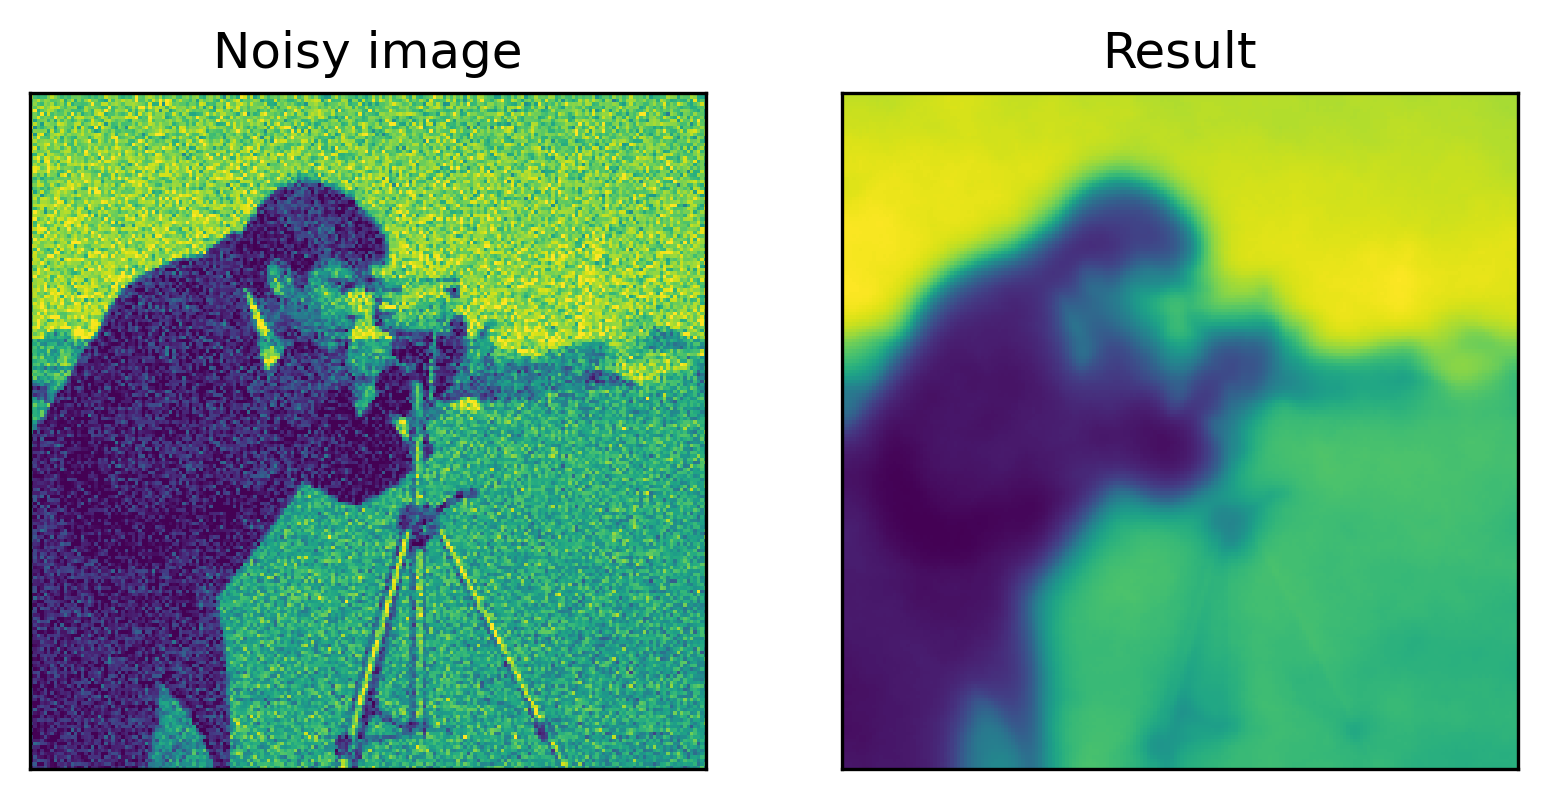

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from myst_nb import glue

from skimage import data
from skimage.util import random_noise
from skimage.transform import resize

# parameters
sigma = 0.1
alpha = 1
dt = 1e-6
niter = 1001
n = 200
coeff = lambda s : 1 + 0*s

# diffusion operator
def L(u,coeff = lambda s : 1 + 0*s):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u = np.zeros((n,n))

for k in range(niter-1):
    u = u - dt*(u - alpha*L(u,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(f_delta)
ax[0].set_title('Noisy image')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u)
ax[1].set_title('Result')
ax[1].set_xticks([])
ax[1].set_yticks([])

glue("linear_diffusion", fig, display=False)

The example before was an example of a linear diffusion equation. Let's now check one non-linear diffusion example, also taken from the mentioned lecture.

Let:
$$r(v) = \log{\left(1+\frac{||v||_2^2}{\varepsilon^2}\right)}.$$
Similarly to before, we end up with an diffusion equation. The diffusion equation it yields is known as Perona-Malik diffusion equation:
$$\partial _t u + u -\alpha\nabla\cdot\left(\frac{\nabla u}{1+\frac{||\nabla u||_2^2}{\varepsilon^2}}\right) = f.$$

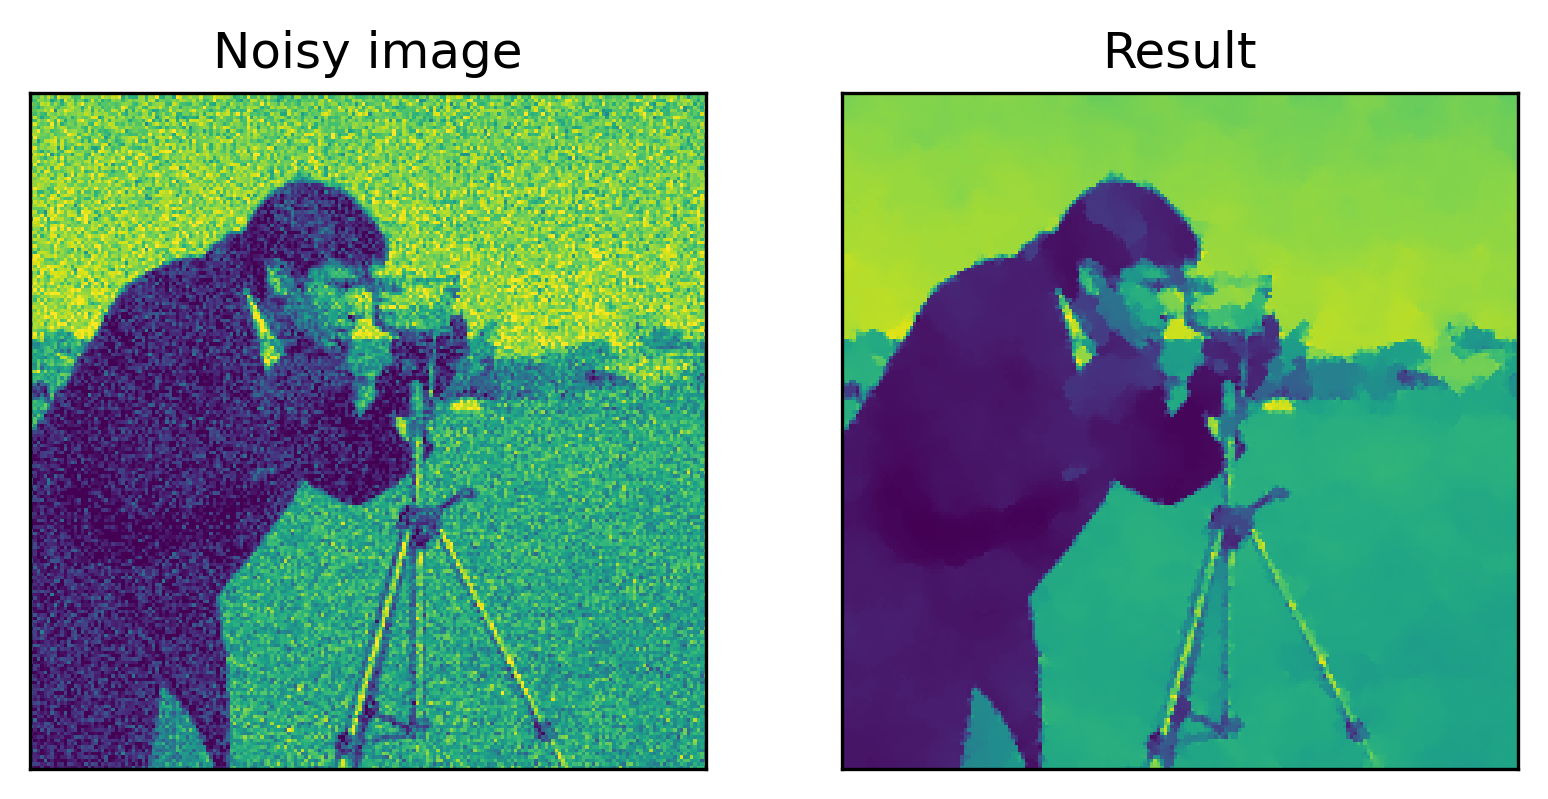

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from myst_nb import glue

from skimage import data
from skimage.util import random_noise
from skimage.transform import resize

# parameters
sigma = 0.1
alpha = 1
dt = 1e-6
niter = 1001
n = 200
coeff = lambda s : 1/(1+1e6*s)

# diffusion operator
def L(u,coeff = lambda s : 1):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u2 = np.zeros((n,n))

for k in range(niter-1):
    u2 = u2 - dt*(u2 - alpha*L(u2,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(f_delta)
ax[0].set_title('Noisy image')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u2)
ax[1].set_title('Result')
ax[1].set_xticks([])
ax[1].set_yticks([])
glue("perona_malik", fig, display=False)

We can see a big improvement compared to solving a linear diffusion equation problem. The reconstructed image contains much more details and has saved the edges exceptionally well.

This result is not that surprising if we observe the regularization factor $r$. By observing the relation between $\varepsilon$ and $||\nabla u||$, we can see that when the norm of the gradient is very small (much smaller than $\varepsilon$), we basically have a linear diffusion problem, while if $||\nabla u||>>\varepsilon$, we have almost no diffusion. That is, $r$ will not increasingly penise larger gradients in this case, and thus will save more information about the edges.

Let's now compare the denoised image with some other commonly used denoising methods. For instance, let's see the pictures yeld by *Median Filter* and *TV-Regularization* methods.

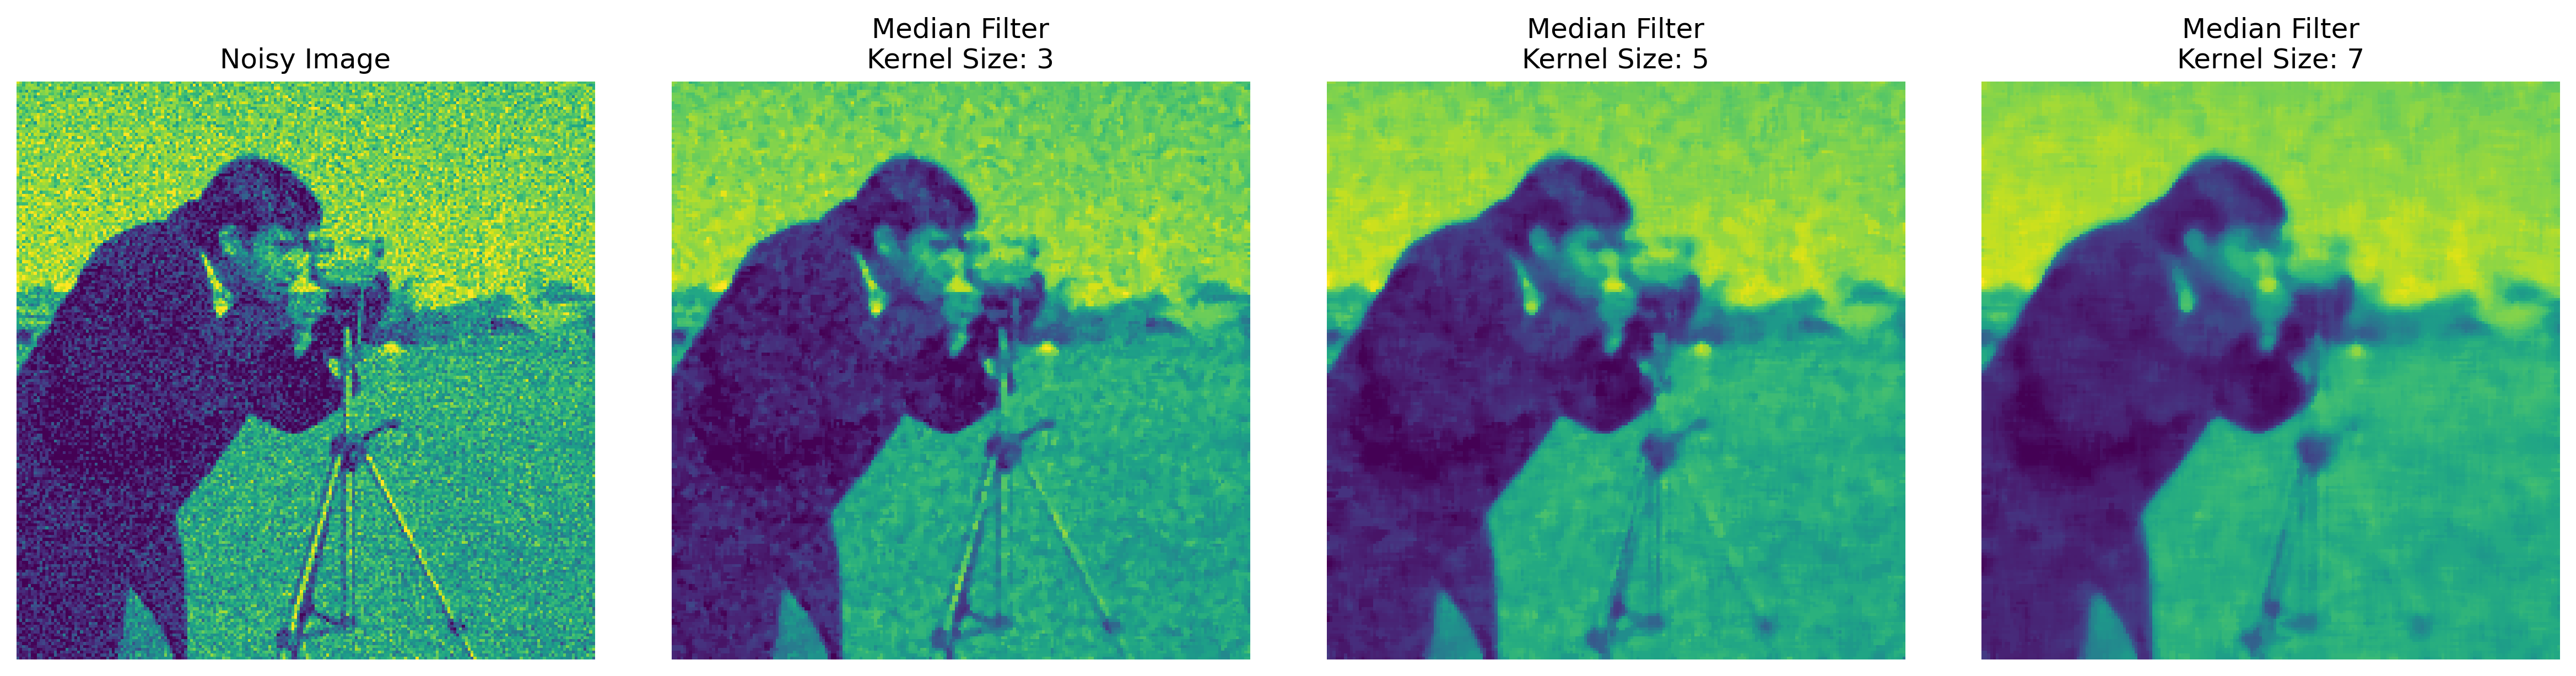

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

# noisy image
f = resize(data.camera(),(n,n))

noisy_image_array = resize(data.camera(),(n,n))

sigma = 0.1
f_delta = random_noise(f,var=sigma**2)
f_delta = f_delta * 255
f_delta = f_delta.astype(np.uint8)

# Median blur with a few different kernel sizes
kernel_sizes = [3, 5, 7]  
denoised_images = []
for kernel_size in kernel_sizes:
    denoised_image_array = cv2.medianBlur(f_delta, kernel_size)
    denoised_images.append(denoised_image_array)

num_plots = len(kernel_sizes) + 1
fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))

axes[0].imshow(f_delta)
axes[0].set_title('Noisy Image')
axes[0].axis('off')

for i in range(len(kernel_sizes)):
    axes[i + 1].imshow(denoised_images[i])
    axes[i + 1].set_title(f'Median Filter\nKernel Size: {kernel_sizes[i]}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

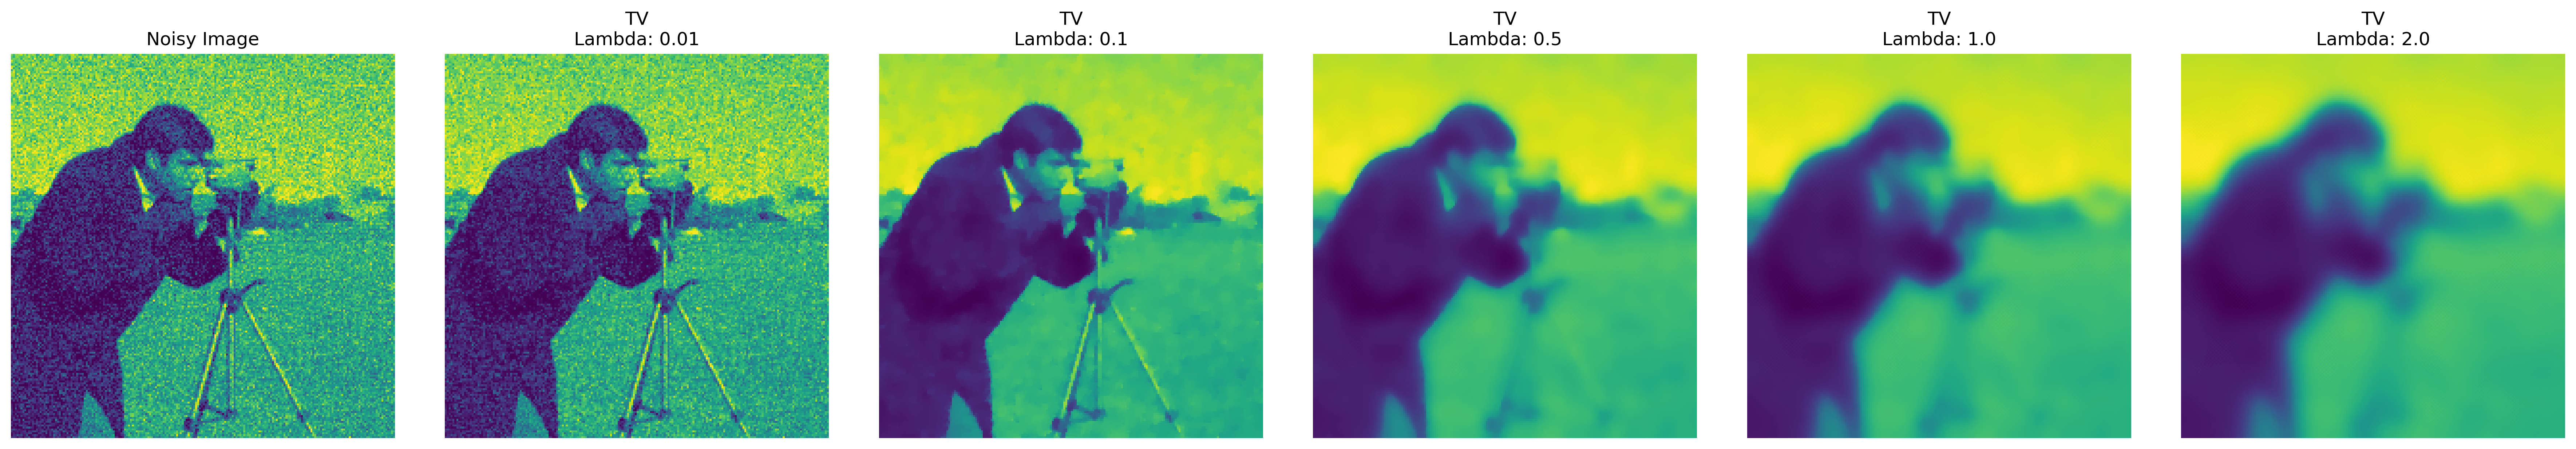

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage.restoration import denoise_tv_chambolle

# noisy image
f = resize(data.camera(),(n,n))

noisy_image_array = resize(data.camera(),(n,n))

sigma = 0.1
f_delta = random_noise(f,var=sigma**2)
f_delta = f_delta * 255
f_delta = f_delta.astype(np.uint8)

# TV-Regularization with a few different values of parameter lambda
lambda_values = [0.01, 0.1, 0.5, 1.0, 2.0] 
denoised_images = []

for lambda_val in lambda_values:
    denoised_image_array = denoise_tv_chambolle(f_delta, weight=lambda_val)
    denoised_images.append(denoised_image_array)

num_plots = len(lambda_values) + 1
fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))

axes[0].imshow(f_delta)
axes[0].set_title('Noisy Image')
axes[0].axis('off')

for i in range(len(lambda_values)):
    axes[i + 1].imshow(denoised_images[i])
    axes[i + 1].set_title(f'TV\nLambda: {lambda_values[i]}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

Let's plot the image for $\lambda = 0.1$ below. It seems to be of the best order of magnitude.

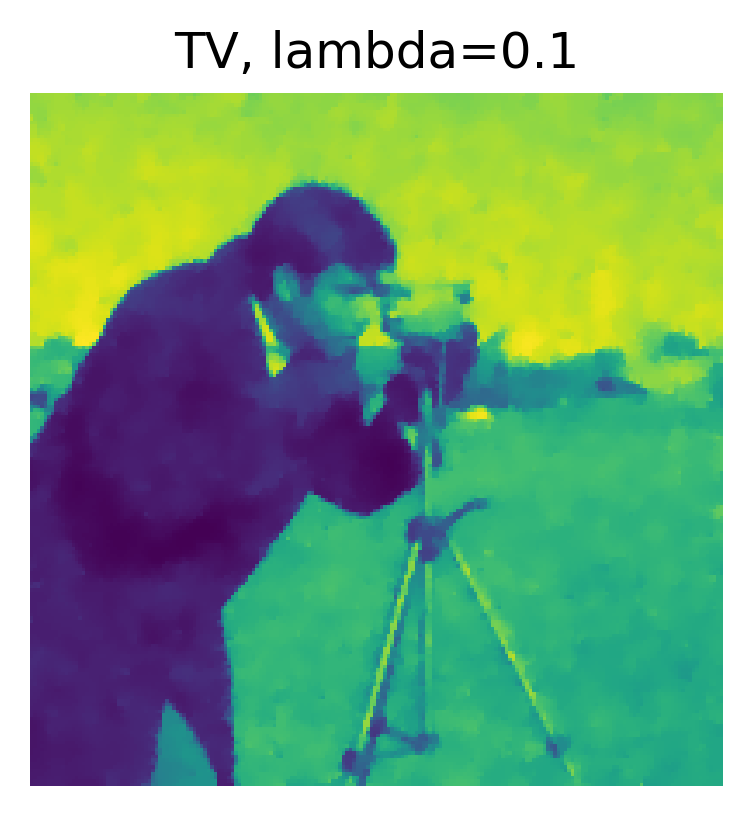

In [5]:
plt.figure(figsize=(4, 3)) 

plt.imshow(denoised_images[1])
plt.title('TV, lambda=0.1')
plt.axis('off')
plt.show()

Roughly said, the *Median filter* fails to preserve colors, while *TV-Regularization* is quite dependent of the parameter lambda, but for the given image is able to reconstruct it better. It seems to preserve more details then the non-linear diffusion method.

Let's vary the parameters in the diffusion models, to see how they change the image compared to the original one. Let's change the number of points to $500$.

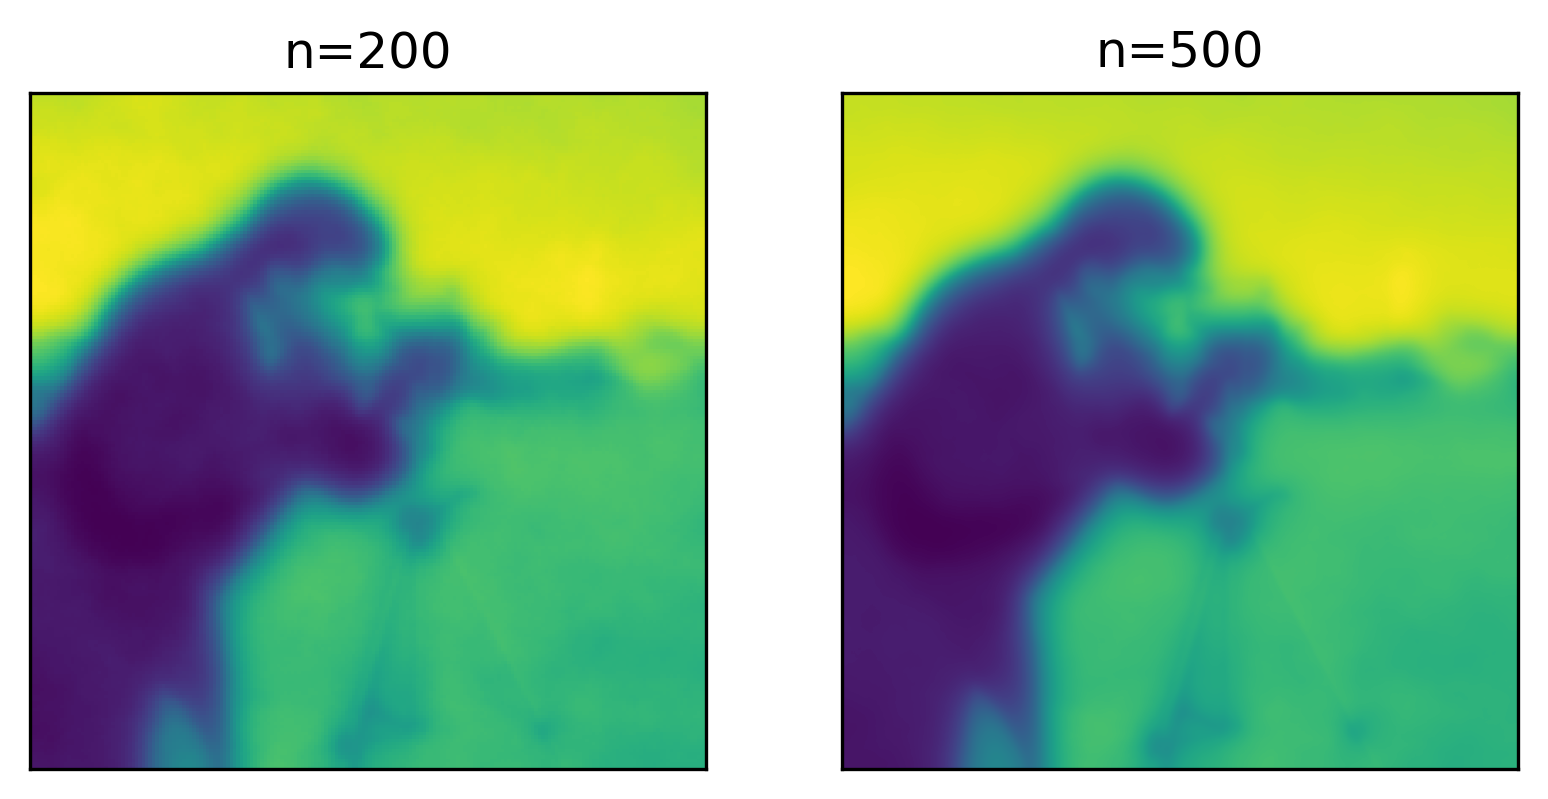

In [6]:
# parameters
sigma = 0.1
alpha = 1
dt = 1e-6
niter = 1001
n = 500
coeff = lambda s : 1 + 0*s

# diffusion operator
def L(u,coeff = lambda s : 1 + 0*s):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u3 = np.zeros((n,n))

for k in range(niter-1):
    u3 = u3 - dt*(u3 - alpha*L(u3,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u)
ax[0].set_title('n=200')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u3)
ax[1].set_title('n=500')
ax[1].set_xticks([])
ax[1].set_yticks([])

glue("linear_diffusion", fig, display=False)

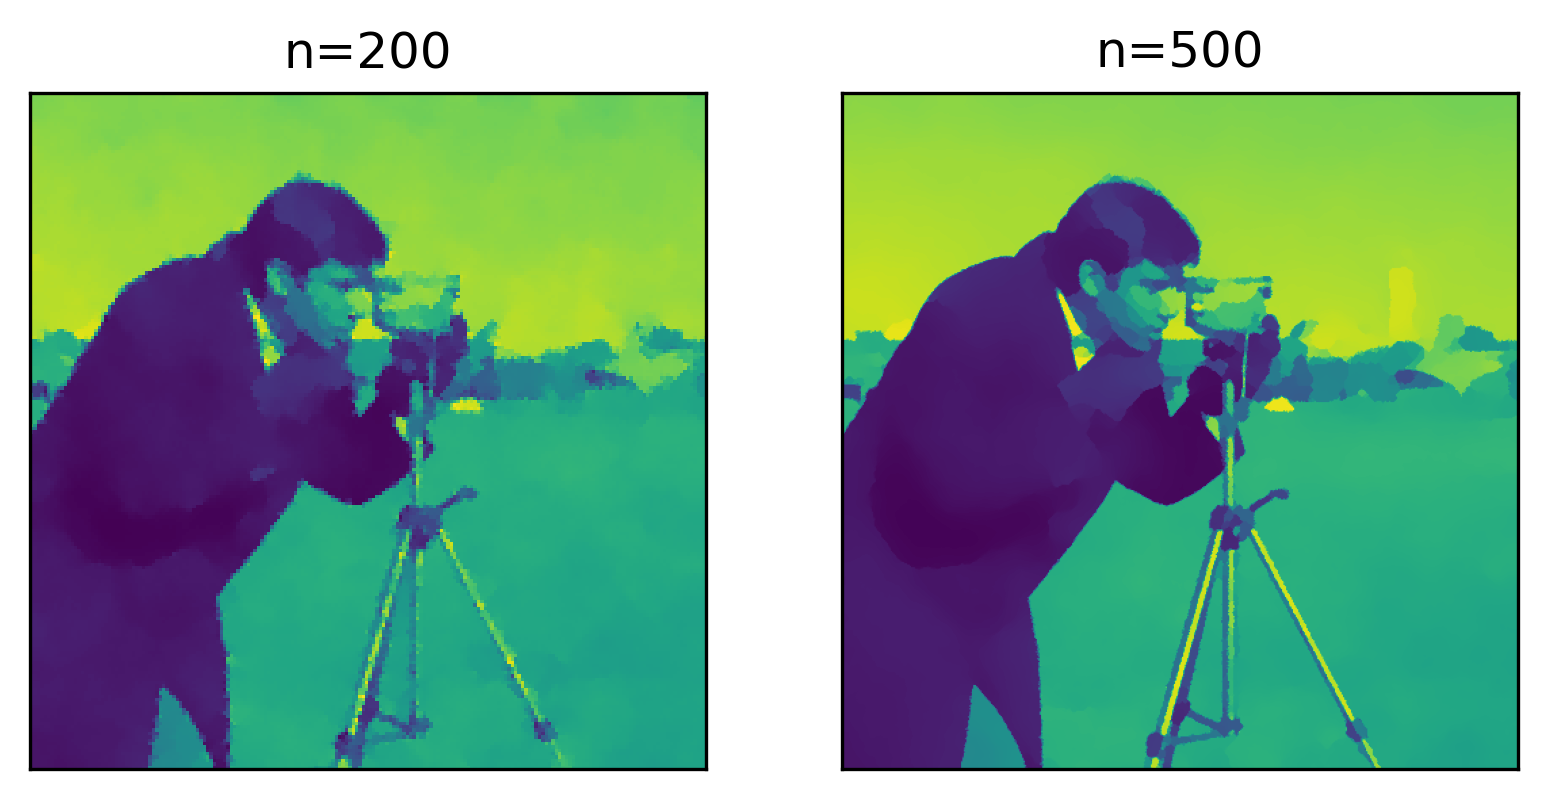

In [7]:
# parameters
sigma = 0.1
alpha = 1
dt = 1e-6
niter = 1001
n = 500
coeff = lambda s : 1/(1+1e6*s)

# diffusion operator
def L(u,coeff = lambda s : 1):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u4 = np.zeros((n,n))

for k in range(niter-1):
    u4 = u4 - dt*(u4 - alpha*L(u4,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u2)
ax[0].set_title('n=200')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u4)
ax[1].set_title('n=500')
ax[1].set_xticks([])
ax[1].set_yticks([])
glue("perona_malik", fig, display=False)

Including more points in the discretization of the function had more effect on the non-linear diffusion, than the linear one. Let's check how the original image looks like, to better analyze the effect.

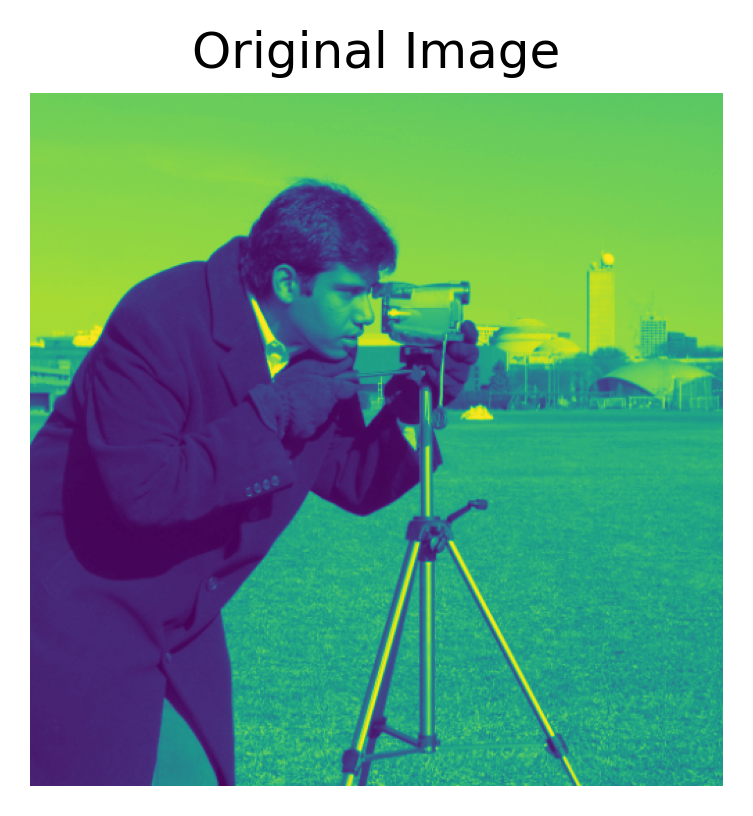

In [8]:
plt.figure(figsize=(4, 3)) 

plt.imshow(f)
plt.title('Original Image')
plt.axis('off')
plt.show()

We can see that increasing the number of points did lose a bit more details, but it did a great job in preserving the edges even further. The measure of success here is quite subjective, but I would say that increasing the number of points, helps restoring the image somewhat.

We could use some similarity measure to quantify the similarity of the restored images to the original one, but such measures sometimes tell different story than the human eye judgement. Thus it is best to observe the results without making any strong conclusions.

Let's also check the effect of the regularization parameter $\alpha$.

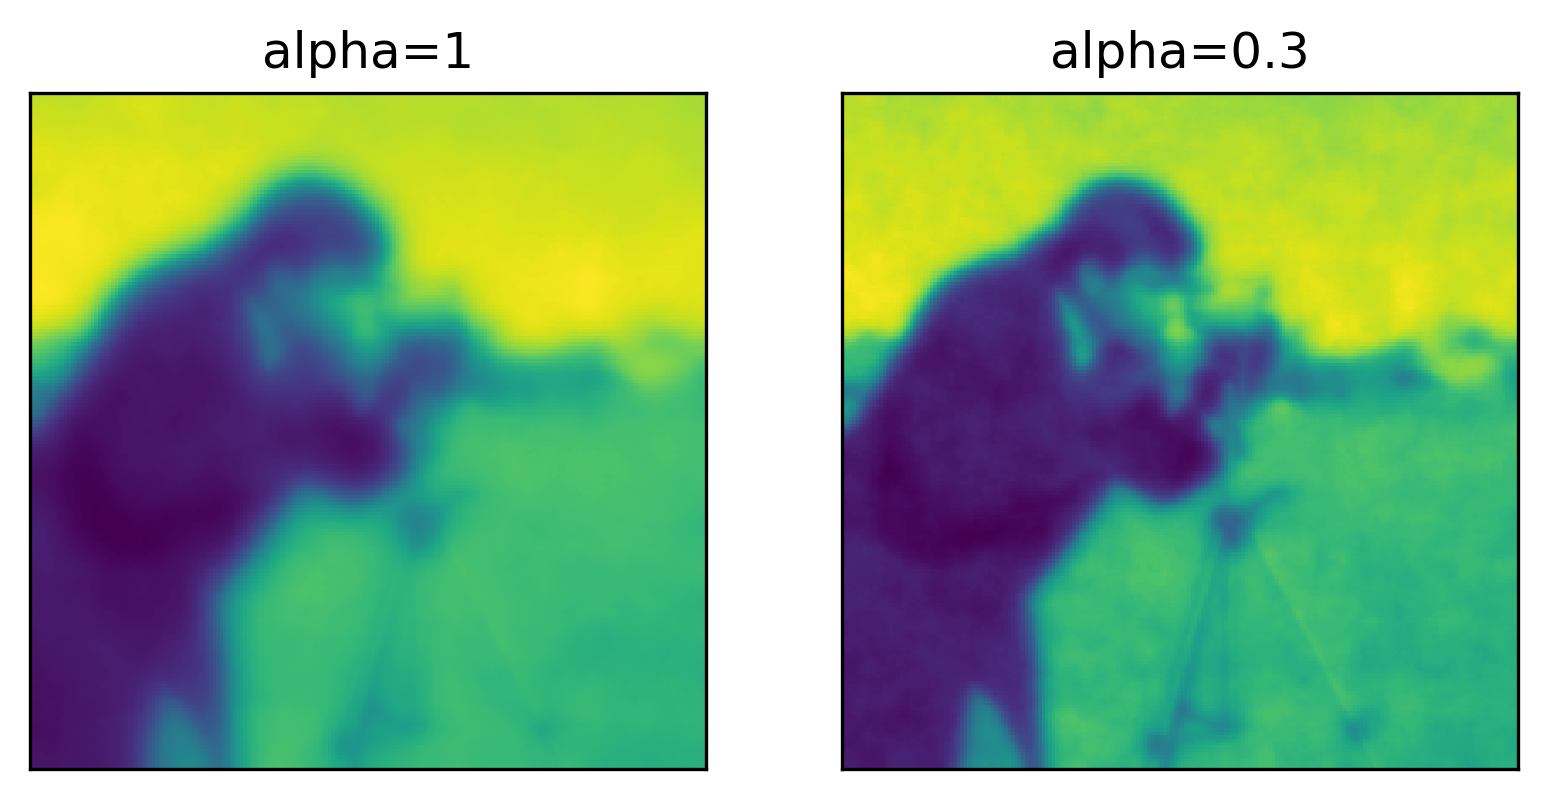

In [9]:
# parameters
sigma = 0.1
alpha = 0.3
dt = 1e-6
niter = 1001
n = 200
coeff = lambda s : 1 + 0*s

# diffusion operator
def L(u,coeff = lambda s : 1 + 0*s):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u3 = np.zeros((n,n))

for k in range(niter-1):
    u3 = u3 - dt*(u3 - alpha*L(u3,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u)
ax[0].set_title('alpha=1')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u3)
ax[1].set_title('alpha=0.3')
ax[1].set_xticks([])
ax[1].set_yticks([])

glue("linear_diffusion", fig, display=False)

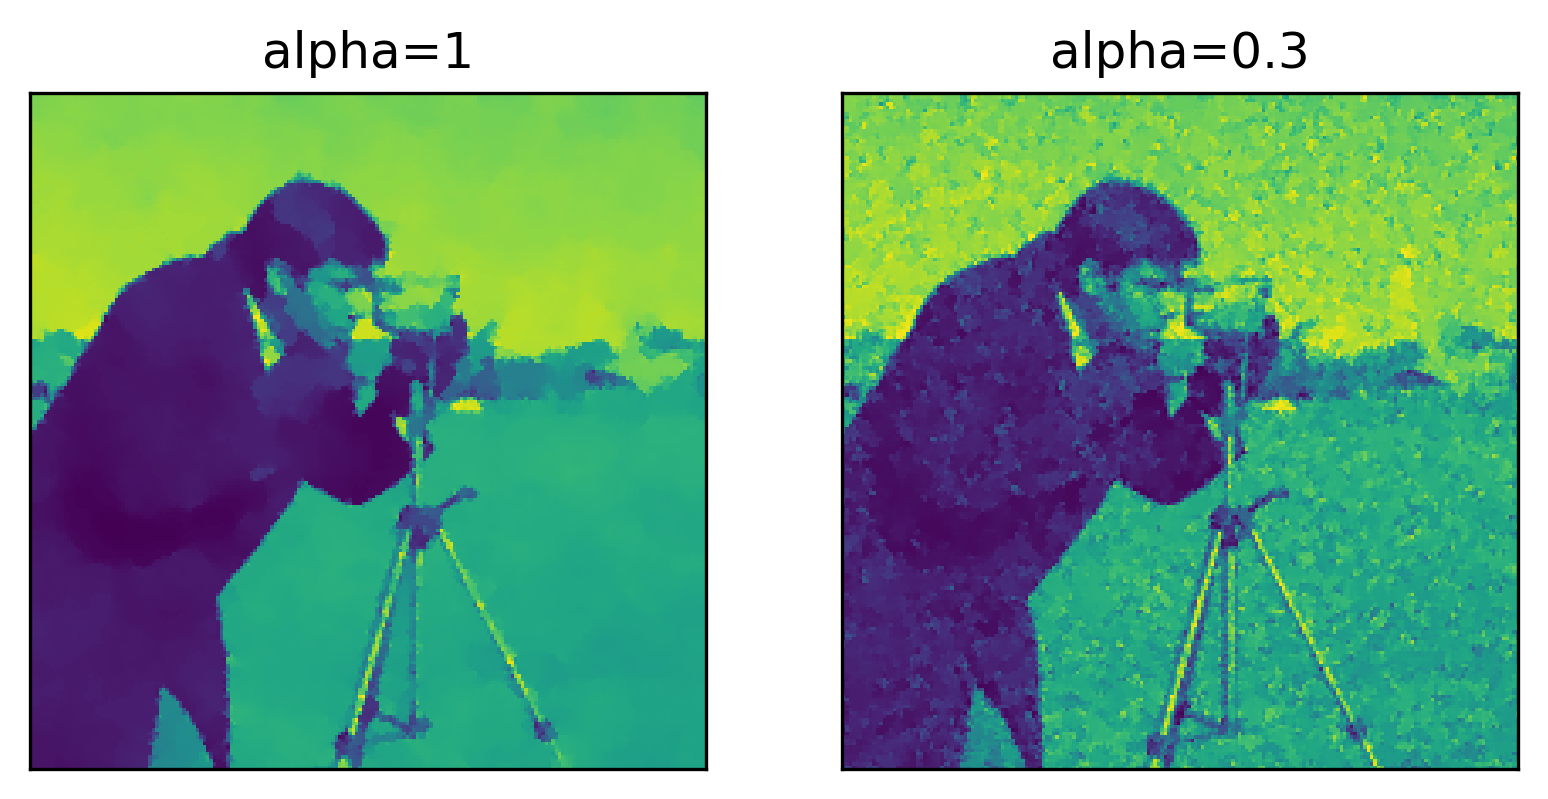

In [10]:
# parameters
sigma = 0.1
alpha = 0.3
dt = 1e-6
niter = 1001
n = 200
coeff = lambda s : 1/(1+1e6*s)

# diffusion operator
def L(u,coeff = lambda s : 1):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u4 = np.zeros((n,n))

for k in range(niter-1):
    u4 = u4 - dt*(u4 - alpha*L(u4,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u2)
ax[0].set_title('alpha=1')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u4)
ax[1].set_title('alpha=0.3')
ax[1].set_xticks([])
ax[1].set_yticks([])
glue("perona_malik", fig, display=False)

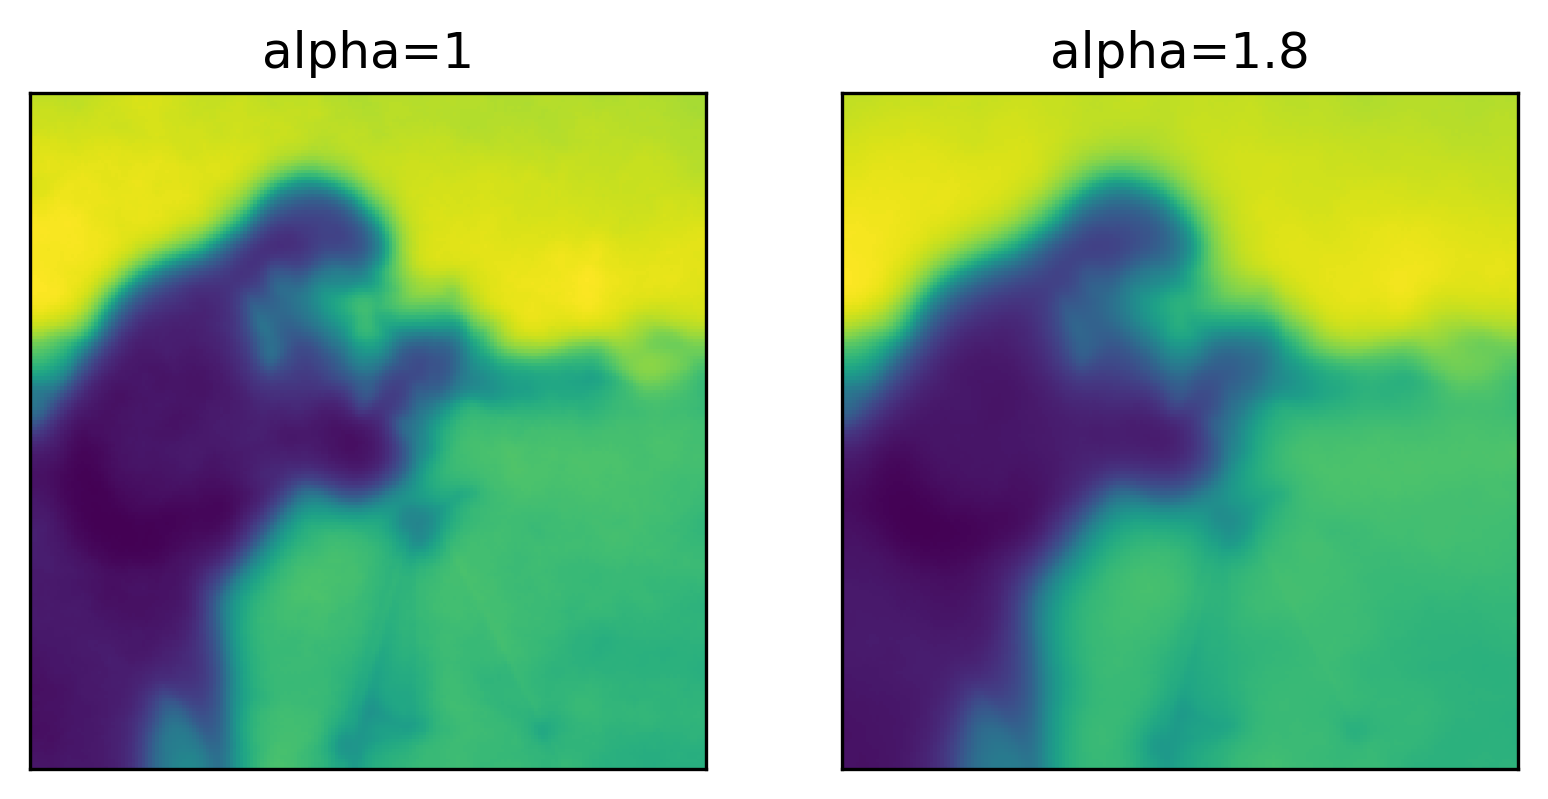

In [11]:
# parameters
sigma = 0.1
alpha = 1.8
dt = 1e-6
niter = 1001
n = 200
coeff = lambda s : 1 + 0*s

# diffusion operator
def L(u,coeff = lambda s : 1 + 0*s):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u3 = np.zeros((n,n))

for k in range(niter-1):
    u3 = u3 - dt*(u3 - alpha*L(u3,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u)
ax[0].set_title('alpha=1')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u3)
ax[1].set_title('alpha=1.8')
ax[1].set_xticks([])
ax[1].set_yticks([])

glue("linear_diffusion", fig, display=False)

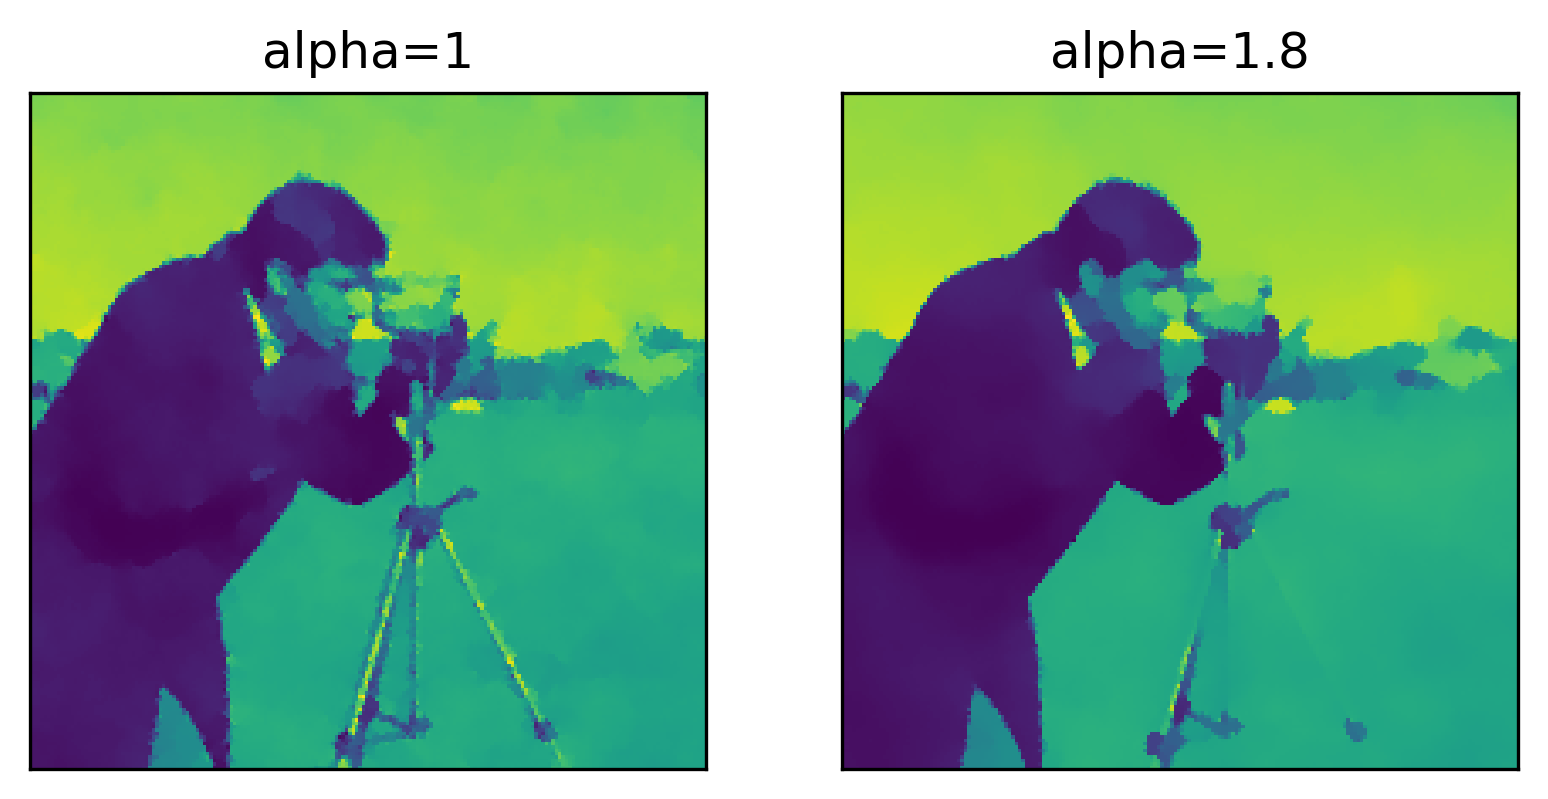

In [12]:
# parameters
sigma = 0.1
alpha = 1.8
dt = 1e-6
niter = 1001
n = 200
coeff = lambda s : 1/(1+1e6*s)

# diffusion operator
def L(u,coeff = lambda s : 1):
    ue = np.pad(u,1,mode='edge') # padd edges to get array of size n+2 x n+2

    # diffusion coefficient (central differences)
    grad_norm = ((ue[2:,1:-1] - ue[:-2,1:-1])/(2/n))**2 + ((ue[1:-1,2:] - ue[1:-1,:-2])/(2/n))**2
    c = np.pad(coeff(grad_norm),1,mode='edge')

    # diffusion term (combination of forward and backward differences)
    uxx = ((c[1:-1,1:-1] + c[2:,1:-1])*(ue[2:,1:-1]-ue[1:-1,1:-1]) - (c[:-2,1:-1]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[:-2,1:-1]))/(2/n**2)
    uyy = ((c[1:-1,1:-1] + c[1:-1,2:])*(ue[1:-1,2:]-ue[1:-1,1:-1]) - (c[1:-1,:-2]+c[1:-1,1:-1])*(ue[1:-1,1:-1]-ue[1:-1,:-2,]))/(2/n**2)

    return uxx + uyy

# noisy image
f = resize(data.camera(),(n,n))
f_delta = random_noise(f,var=sigma**2)

# solve evolution equation
u4 = np.zeros((n,n))

for k in range(niter-1):
    u4 = u4 - dt*(u4 - alpha*L(u4,coeff)) + dt*f_delta

# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u2)
ax[0].set_title('alpha=1')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(u4)
ax[1].set_title('alpha=1.8')
ax[1].set_xticks([])
ax[1].set_yticks([])
glue("perona_malik", fig, display=False)

As we would expect from such parameter, decreasing it reduces oversmoothing, but can possibly be uneffective in dealing with the original noise. Increasing it too much can lose us important information from the image.

All in all, we can see the importance of the parameters of the diffusion method. Finding optimal parameters can be time and resource consuming, but is unavoidable in order to be sure we are getting the most out of the image.

To conclude, this approach has its strenghts and weaknesses, but is definitely a viable option when dealing with some noise sources in imaging. It is definitely an interesting approach to the denoising problem and a very clever use of the variational formulation of the problem.